In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print(tf.config.experimental.list_physical_devices('GPU'))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, GRU
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint

from tqdm import tqdm


# Load dataset

In [9]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X=[]
y=[]

folders = ["sample296","video1","video2","sample"]

for folder in folders:
    if not os.path.exists(f"dataset/{folder}"):
        print(f"dataset/{folder} doesnt exist")
        continue
        
    print(f"Loading shots from dataset/{folder}")
        
    for shot_csv in tqdm(sorted(os.listdir(f'dataset/{folder}'))):
        data = pd.read_csv(os.path.join(f'dataset/{folder}', shot_csv))
        
        if folder == "train":
            revert_data= data.copy()
            for feature in data.columns:
                if feature[-2:]=="_x":
                    revert_data[feature] = 1 - data[feature]
            data = revert_data

        features = data.loc[:, data.columns != 'shot']

        X.append(features.to_numpy())
        y.append(data["shot"].iloc[0])
    
X = np.stack(X, axis=0)

y = np.array(y)
X = np.array(X)

print(f"Loaded {len(y)} shots for training")

X_test=[]
y_test=[]

folders = ["sample296"]
for folder in folders:
    for shot_csv in sorted(os.listdir(f'dataset/{folder}')):
    
        data = pd.read_csv(os.path.join(f'dataset/{folder}',shot_csv ))

        if folder == "test":
                revert_data= data.copy()
                for feature in data.columns:
                    if feature[-2:]=="_x":
                        revert_data[feature] = 1 - data[feature]
                data = revert_data


        features = data.loc[:, data.columns != 'shot']

        X_test.append(features.to_numpy())
        y_test.append(data["shot"].iloc[0])
    
X_test = np.stack(X_test, axis=0)

y_test = np.array(y_test)
X_test = np.array(X_test)

print(f"Loaded {len(y_test)} shots for test")
    

Loading shots from dataset/sample296


100%|██████████| 207/207 [00:01<00:00, 193.29it/s]


Loading shots from dataset/video1


100%|██████████| 99/99 [00:00<00:00, 244.67it/s]


Loading shots from dataset/video2


100%|██████████| 143/143 [00:00<00:00, 257.16it/s]


Loading shots from dataset/sample


100%|██████████| 13/13 [00:00<00:00, 97.52it/s]


Loaded 462 shots for training
Loaded 207 shots for test


# Display shot repartition

['no_shot', 'boast', 'rail', 'cross_court', 'serve'] [183, 62, 63, 67, 87]


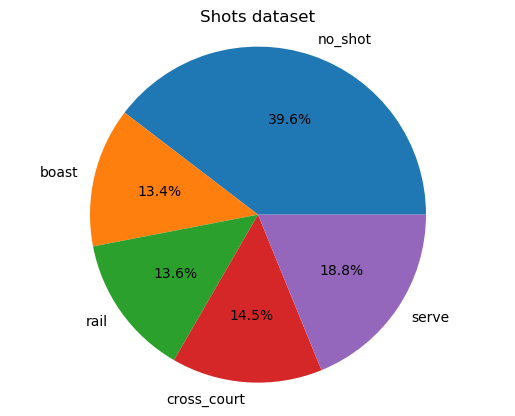

In [10]:
import numpy as np
# if using a Jupyter notebook, include:
%matplotlib inline

shots = list(set(y))
occurences = [np.count_nonzero(y == shot) for shot in shots]
print(shots, occurences)

fig, ax = plt.subplots()
ax.pie(occurences, labels=shots, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Shots dataset')

plt.show()

In [11]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, shuffle= True)

print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")

print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))
print(nb_cat)

Shape of train features : (30, 26)
Shape of val features : (30, 26)
Total categories:  5
Total categories:  5
5


In [12]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_cat)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=nb_cat)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_cat)

y_train = np.array(y_train)
X_train = np.array(X_train)
#X_train = np.expand_dims(X_train, axis=-1)

y_val = np.array(y_val)
X_val = np.array(X_val)
#X_val = np.expand_dims(X_val, axis=-1)

y_test = np.array(y_test)
X_test = np.array(X_test)

In [13]:
assert len(le.classes_) == nb_cat

In [14]:
print("X_train Shape: ", X_train.shape)
print("X_val Shape: ", X_val.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_val Shape: ", y_val.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (309, 30, 26)
X_val Shape:  (153, 30, 26)
X_test Shape:  (207, 30, 26)
y_train Shape:  (309, 5)
y_val Shape:  (153, 5)
y_test Shape:  (207, 5)


In [14]:
m1=Sequential()
m1.add(GRU(units=24, dropout=0.1, input_shape=( 30, 26)))
m1.add(Dropout(0.2))
m1.add(Dense(units = 8, activation = 'relu'))
m1.add(Dense(units = nb_cat, activation = 'softmax'))

c:\Users\Umais\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
m1.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
m1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24)             │         3,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989 (15.58 KB)

 Trainable params: 3,989 (15.58 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model
m1 = Sequential()
m1.add(LSTM(units=64, return_sequences=True, input_shape=(30, 26), dropout=0.2))
m1.add(LSTM(units=32, dropout=0.2))
m1.add(BatchNormalization())
m1.add(Dense(units=64, activation='relu'))
m1.add(Dropout(0.3))
m1.add(Dense(units=nb_cat, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
m1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
m1.summary()

c:\Users\Umais\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 64)         │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,277 (149.52 KB)

 Trainable params: 38,213 (149.27 KB)

 Non-trainable params: 64 (256.00 B)

In [24]:
filepath = "2rnn_weights.keras" #.hdf5
checkpointer = ModelCheckpoint(filepath=filepath, verbose=False, save_best_only=True)
hist = m1.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               batch_size = 32,
                epochs=100, 
                verbose = 1, 
                callbacks=[checkpointer]
             )

loss, accuracy = m1.evaluate(X_val, y_val)
print(f"Accuracy on validation dataset = {accuracy}")

m1.load_weights(filepath)

loss, accuracy = m1.evaluate(X_val, y_val)
print(f"Accuracy on validation dataset = {accuracy}")

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3526 - loss: 1.5222 - val_accuracy: 0.4248 - val_loss: 1.4690
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.3725 - loss: 1.5007 - val_accuracy: 0.4248 - val_loss: 1.4691
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3883 - loss: 1.4957 - val_accuracy: 0.4248 - val_loss: 1.4691
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3659 - loss: 1.5218 - val_accuracy: 0.4248 - val_loss: 1.4690
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4165 - loss: 1.4505 - val_accuracy: 0.4248 - val_loss: 1.4699
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3962 - loss: 1.4904 - val_accuracy: 0.4248 - val_loss: 1.4709
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.3950 - loss: 1.4816 - val_accuracy: 0.4248 - val_loss: 1.4716
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4315 - loss: 1.4445 - val_accuracy: 0.

In [25]:
m1.save("rnn_weights_saved_5dec.h5")

In [18]:
m1.save("rnn_my_model.keras")

# Confusion matrix

In [19]:
loss, accuracy = m1.evaluate(X_test, y_test)
print(f"Accuracy on test dataset = {accuracy:.3f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3846 - loss: 2.0103
Accuracy on test dataset = 0.385


In [20]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn


preds = m1.predict(X_test)
test_predictions = np.argmax(preds, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step


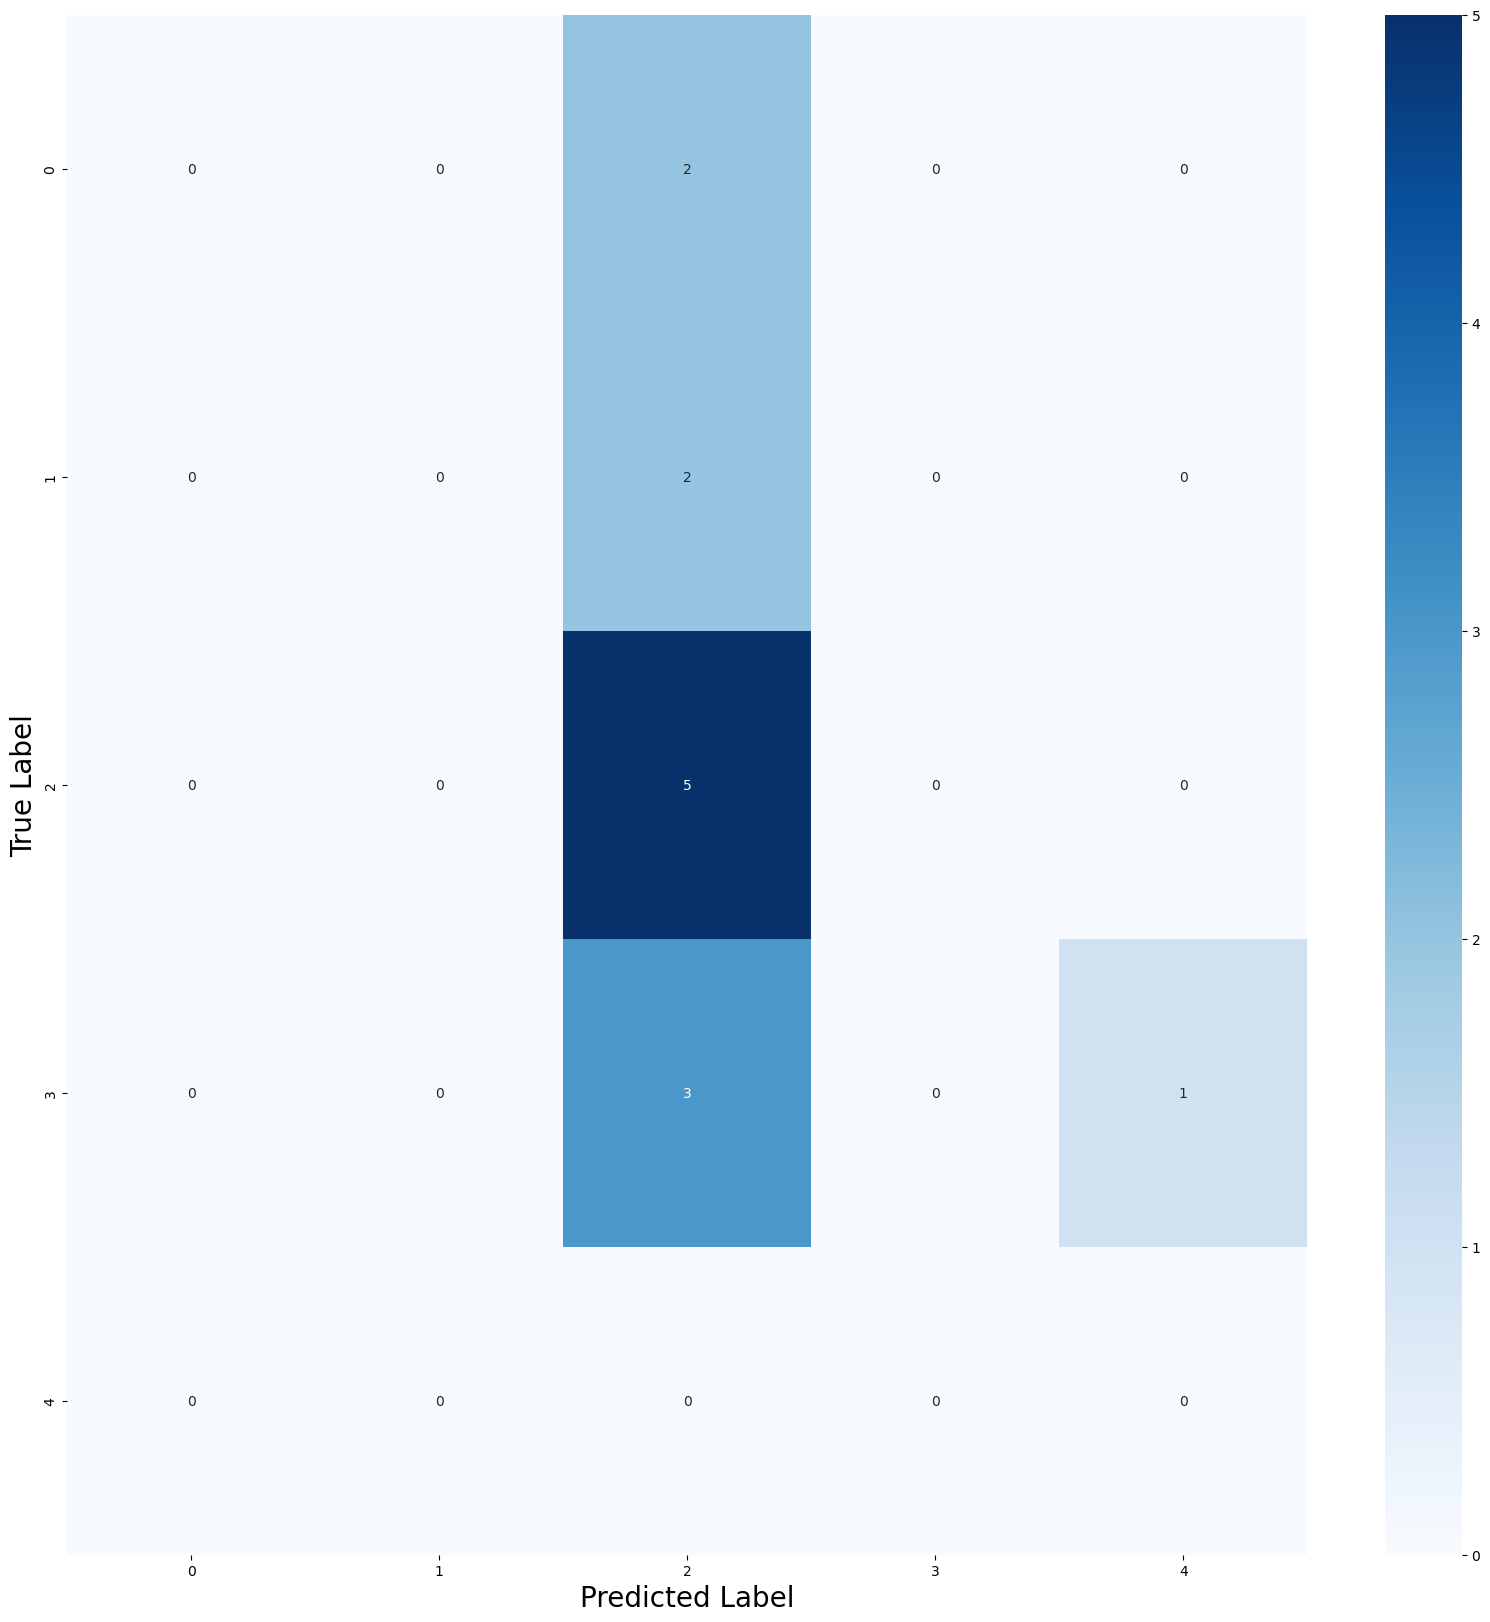

In [21]:
# Plot the confusion matrix
%matplotlib inline


cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_predictions)


df_cm = pd.DataFrame(
    cm, index=le.classes_, columns=le.classes_
)
plt.figure(figsize=(20, 20))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.show()

# Display a few examples

In [22]:
import imageio
from tensorflow_docs.vis import embed

def to_gif(shot):
    height = 500
    width = 500
    
    KEYPOINTS = np.array(["nose",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle"])
    
    EDGES = {
        ("nose", "left_shoulder"): "m",
        ("nose", "right_shoulder"): "c",
        ("left_shoulder", "left_elbow"): "m",
        ("left_elbow", "left_wrist"): "m",
        ("right_shoulder", "right_elbow"): "c",
        ("right_elbow", "right_wrist"): "c",
        ("left_shoulder", "right_shoulder"): "y",
        ("left_shoulder", "left_hip"): "m",
        ("right_shoulder", "right_hip"): "c",
        ("left_hip", "right_hip"): "y",
        ("left_hip", "left_knee"): "m",
        ("left_knee", "left_ankle"): "m",
        ("right_hip", "right_knee"): "c",
        ("right_knee", "right_ankle"): "c",
    }
    
    COLORS = {"c": (255, 255, 0), "m": (255, 0, 255), "y": (0, 255, 255)}
    
    
    frames=np.zeros((30, height, width, 3), np.uint8)
    for i in range(len(shot)):
        shot_inst = shot[i, :]
        for k in range(13):
            cv2.circle(
                frames[i],
                (
                    int(shot_inst[2*k+1] * width),
                    int(shot_inst[2*k] * height),
                ),
                radius=3,
                color=(0, 255, 0),
                thickness=-1,
            )
            
        for edge in EDGES.items():
            k = np.argwhere(KEYPOINTS == edge[0][0])[0][0]
            j = np.argwhere(KEYPOINTS == edge[0][1])[0][0]
            cv2.line(
                frames[i],
                (
                    int(shot_inst[2*k+1] * width),
                    int(shot_inst[2*k] * height),
                ),
                (
                    int(shot_inst[2*j+1] * width),
                    int(shot_inst[2*j] * height),
                ),
                color=COLORS[edge[1]],
                thickness=2,
            )
    
    return frames.astype(np.uint8)
        




ModuleNotFoundError: No module named 'tensorflow_docs'

In [24]:
import random
k = random.randint(0, len(y_test))

converted_images = to_gif(X_test[k, :, :])
imageio.mimsave("animation.gif", converted_images, fps=15)

print("Predicts:")
for i in range(nb_cat):
    print(f"{le.classes_[i]} = {preds[k, i]*100:.1f}%")
    

print(f"\nGT: {le.classes_[np.argmax(y_test[k])]}")


embed.embed_file("animation.gif")

NameError: name 'to_gif' is not defined

## A bad classification

In [25]:
mismatch = np.argwhere(np.argmax(y_test, axis = 1) != test_predictions).flatten()
print(mismatch)

k = mismatch[random.randint(0, len(mismatch) - 1)]

print(k)
converted_images = to_gif(X_test[k, :, :])
imageio.mimsave("animation.gif", converted_images, fps=15)

print("Predicts:")
for i in range(nb_cat):
    print(f"{le.classes_[i]} = {preds[k, i]*100:.1f}%")
    

print(f"\nGT: {le.classes_[np.argmax(y_test[k])]}")


embed.embed_file("animation.gif")

[ 0  1  2  3  9 10 11 12]
10


NameError: name 'to_gif' is not defined

RNN classifier with sqlite database

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

X=[]
y=[]

folders = ["sample-296eb","video1","video2"]

for folder in folders:
    if not os.path.exists(f"dataset/{folder}"):
        print(f"dataset/{folder}/shots/ doesnt exist")
        continue
        
    print(f"Loading shots from dataset/{folder}")
        
    for shot_csv in tqdm(sorted(os.listdir(f'dataset/{folder}'))):
        data = pd.read_csv(os.path.join(f'dataset/{folder}', shot_csv))
        
        if folder == "train":
            revert_data= data.copy()
            for feature in data.columns:
                if feature[-2:]=="_x":
                    revert_data[feature] = 1 - data[feature]
            data = revert_data

        features = data.loc[:, data.columns != 'shot']

        X.append(features.to_numpy())
        y.append(data["shot"].iloc[0])
    
X = np.stack(X, axis=0)

y = np.array(y)
X = np.array(X)

print(f"Loaded {len(y)} shots for training")

X_test=[]
y_test=[]

folders = ["sample"]
for folder in folders:
    for shot_csv in sorted(os.listdir(f'dataset/{folder}')):
    
        data = pd.read_csv(os.path.join(f'dataset/{folder}',shot_csv ))

        if folder == "test":
                revert_data= data.copy()
                for feature in data.columns:
                    if feature[-2:]=="_x":
                        revert_data[feature] = 1 - data[feature]
                data = revert_data


        features = data.loc[:, data.columns != 'shot']

        X_test.append(features.to_numpy())
        y_test.append(data["shot"].iloc[0])
    
X_test = np.stack(X_test, axis=0)

y_test = np.array(y_test)
X_test = np.array(X_test)

print(f"Loaded {len(y_test)} shots for test")
    

In [5]:
import sqlite3
import numpy as np
import pickle

# Path to your SQLite database
db_path = r"sample_db\annotations.db"

# Function to get the first table name in the database
def get_table_name(conn):
    """
    Get the name of the first table in the SQLite database.
    :param conn: SQLite connection object.
    :return: Name of the first table, or None if no table exists.
    """
    query = "SELECT name FROM sqlite_master WHERE type='table' LIMIT 1"
    result = conn.execute(query).fetchone()
    return result[0] if result else None

# Function to load data from the database
def load_data_from_database(conn, table_name):
    """
    Load data from the SQLite database for a specific table.
    :param conn: SQLite connection object.
    :param table_name: Table name to query.
    :return: Features (X) and labels (y) as numpy arrays.
    """
    query = f"SELECT * FROM {table_name}"
    cursor = conn.execute(query)
    X = []
    y = []
    
    for row in cursor:
        shot_type = row[2]  # Column 3 (shot_type)
        keypoints_blob = row[3]  # Column 4 (keypoints)
        keypoints = pickle.loads(keypoints_blob)  # Deserialize keypoints
        
        X.append(keypoints)
        y.append(shot_type)
    
    return np.array(X), np.array(y)

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# Get the first table name
table_name = get_table_name(conn)
if table_name:
    print(f"Found table '{table_name}' in the database.")
    
    # Load data from the table
    try:
        X, y = load_data_from_database(conn, table_name)
        print(f"Loaded {len(y)} entries from the database.")
    except Exception as e:
        print(f"Error loading data: {e}")
else:
    print("No table found in the database.")

# Close the database connection
conn.close()

# Print summary only if data is loaded
if 'X' in locals() and 'y' in locals():
    print(f"Data: X={X.shape}, y={y.shape}")


Found table 'annotations' in the database.
Loaded 496 entries from the database.
Data: X=(496, 17, 2), y=(496,)


In [6]:
import sqlite3
import numpy as np
import pickle
from tqdm import tqdm  # For progress tracking

# Path to your SQLite database
db_path = r"sample_db\annotations.db"

# Connect to the SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Query to retrieve all data from the table
print("Loading data from the database")

# Automatically detect table name
def get_table_name(conn):
    """
    Get the name of the first table in the SQLite database.
    :param conn: SQLite connection object.
    :return: Name of the first table, or None if no table exists.
    """
    query = "SELECT name FROM sqlite_master WHERE type='table' LIMIT 1"
    result = conn.execute(query).fetchone()
    return result[0] if result else None

table_name = get_table_name(conn)
if not table_name:
    print("No table found in the database.")
    exit()

print(f"Found table '{table_name}' in the database.")

# Load training data
X = []
y = []

query = f"SELECT * FROM {table_name}"
rows = cursor.execute(query).fetchall()

for row in tqdm(rows, desc="Processing database rows"):
    shot_type = row[2]  # Assuming 'shot_type' is in column 3
    keypoints_blob = row[3]  # Assuming 'keypoints' is in column 4

    try:
        # Deserialize keypoints using pickle
        keypoints = pickle.loads(keypoints_blob)
        X.append(keypoints)
        y.append(shot_type)
    except Exception as e:
        print(f"Error deserializing keypoints for row {row[0]}: {e}")

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

print(f"Loaded {len(y)} entries from the database.")

# Close the database connection
conn.close()

# Print summary
print(f"Data shapes: X={X.shape}, y={y.shape}")


Loading data from the database
Found table 'annotations' in the database.


Processing database rows: 100%|██████████| 496/496 [00:00<00:00, 28247.16it/s]

Loaded 496 entries from the database.
Data shapes: X=(496, 17, 2), y=(496,)


In [7]:
print(f"First keypoints set:\n{X[0]}")
print(f"First label: {y[0]}")


First keypoints set:
[[0.8029175  0.40896645]
 [0.35752916 0.8136129 ]
 [0.340575   0.3695252 ]
 [0.79783934 0.3029532 ]
 [0.40976515 0.0384626 ]
 [0.02819799 0.6618419 ]
 [0.6180645  0.06756657]
 [0.08932777 0.8102602 ]
 [0.7516415  0.40699014]
 [0.8033494  0.507264  ]
 [0.2962062  0.5921022 ]
 [0.57471204 0.66593134]
 [0.56174415 0.23719992]
 [0.41420996 0.90215117]
 [0.03428408 0.3105465 ]
 [0.33038288 0.3016642 ]
 [0.32355484 0.6557766 ]]
First label: serve


In [10]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle= True)

print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")

print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))
print(nb_cat)

Shape of train features : (17, 2)
Shape of val features : (17, 2)
Total categories:  3
Total categories:  3
3


In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense


model = Sequential([
    Flatten(input_shape=(17, 2)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')  # Adjust output units to number of unique labels
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


In [5]:
import sqlite3
import numpy as np
from tqdm import tqdm  # For progress tracking

# Initialize data containers
X = []
y = []

# Path to the SQLite database
db_path = r"sample_db\annotations.db"

# Connect to the SQLite database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Query to retrieve all training data
print("Loading training data from the database")

# Replace 'your_table_name' with the actual table name
cursor.execute("SELECT Video_id, shot_type, keypoints FROM annotations")
rows = cursor.fetchall()

for row in tqdm(rows, desc="Processing training data"):
    video_name, shot_type, keypoints_blob = row
    
    # Deserialize keypoints blob
    #keypoints = np.array(eval(keypoints_blob))  # Assuming keypoints are stored as a string representation of a list

    sanitized_blob = keypoints_blob.replace('\x00', '')  # Remove null bytes
    keypoints = np.array(eval(sanitized_blob))
    # Flip keypoints horizontally if needed (for training set)
    if "train" in video_name.lower():  # Adjust condition based on your naming convention
        keypoints[:, 0] = 1 - keypoints[:, 0]  # Assuming keypoints are [x, y] normalized coordinates

    X.append(keypoints)
    y.append(shot_type)

# Convert to NumPy arrays
X = np.stack(X, axis=0)
y = np.array(y)

print(f"Loaded {len(y)} shots for training")

# Separate testing data if necessary
X_test = []
y_test = []

print("Loading testing data from the database")

# Query to retrieve all testing data (adjust as needed for your setup)
cursor.execute("SELECT video_name, shot_type, keypoints FROM your_table_name")
rows = cursor.fetchall()

for row in tqdm(rows, desc="Processing testing data"):
    video_name, shot_type, keypoints_blob = row
    
    # Deserialize keypoints blob
    keypoints = np.array(eval(keypoints_blob))  # Assuming keypoints are stored as a string representation of a list

    # Flip keypoints horizontally if needed
    if "test" in video_name.lower():  # Adjust condition based on your naming convention
        keypoints[:, 0] = 1 - keypoints[:, 0]  # Assuming keypoints are [x, y] normalized coordinates

    X_test.append(keypoints)
    y_test.append(shot_type)

# Convert to NumPy arrays
X_test = np.stack(X_test, axis=0)
y_test = np.array(y_test)

print(f"Loaded {len(y_test)} shots for testing")

# Close the database connection
conn.close()


Loading training data from the database


Processing training data:   0%|          | 0/496 [00:00<?, ?it/s]


TypeError: a bytes-like object is required, not 'str'